# Task 2 - Granger Causality on a Stock Market Example

## Example
### Scenario
Analysis of two stock indicies movements to inspect whether on Ganger causes the other. 
A common pair to condiser would be the S&P 500 and the Dow Jones Industrial Average, as movements in one are often thought to influence the other. 
However, as a German looking at German stocks or stock indices seems very tempting. Therefore this example will look at the Dax and the MDAX and inspect whether one Granger causes the other. 
For example if movements in the MDAX Granger-cause movements in the DAX this could indicate that mid-cap stocks movements help predict the larger market trends in Germany.

### Steps
1. Import Data from yfinance libarary for a fixed timeframe
2. Define reusable functions (Stationarity Check, Granger Causality test and Visualization)
3. Check timeframes for stationarity
4. Perform Granger Causality Tests
5. Visualization

### Basic Formulas
1. Granger Causality between two time series:
* X1(t)= ∑(i=1 to p) α11, iX1(t - i) + ∑(i=1 to q) α12, iX2(t - i) + ϵ1(t)
* X2(t)= ∑(i=1 to p) α21, iX1(t - i) + ∑(i=1 to q') α22, iX2(t - i) + ϵ2(t)
2. F-Test for Granger Causality:
* F = ((RSSr - RSSu)/m) / (RSSu/(n-k)) 
* RSSr: residual sum of squares of restricted model, RSSu: residual sum of squares of unrestricted model, m: number of restrictions, n: number of observations, k: number of parameters in unrestricted model


In [96]:
#Imports
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

In [97]:
# Data from yf library for a set timeframe to enable reproducability
start_date = '2019-05-01'
end_date = '2024-05-01'

dax = yf.download("^GDAXI", start=start_date, end=end_date, interval='1d')
mdax = yf.download("^MDAXI", start=start_date, end=end_date, interval='1d')

data = pd.DataFrame({
    'DAX': dax['Adj Close'],
    'MDAX': mdax['Adj Close']
})

data.info()


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1273 entries, 2019-05-02 to 2024-04-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DAX     1273 non-null   float64
 1   MDAX    1273 non-null   float64
dtypes: float64(2)
memory usage: 29.8 KB


In [98]:
# Reusable Methods

#Stationarity Check (Mean, variance, autocorrelation are constant over time)
#Using Augmented Dickey-Fuller (ADF) with p < 0.05
def check_stationarity(series, cutoff=0.05):
    result = adfuller(series, autolag='AIC')
    print(f'ADF statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')
    
    if result[1] < cutoff:
        print("The series is stationary")
    else:
        print("The series is not stationary and may need differencing")

# Granger Causality Test Summary
def compile_granger_results(granger_results, max_lags):
    rows = []

    for lag in range(1, max_lags + 1):
        test_results = granger_results[lag][0]
        f_test_stat = test_results['ssr_ftest'][0]
        p_value_f = test_results['ssr_ftest'][1]
        chi_test_stat = test_results['ssr_chi2test'][0]
        p_value_chi2 = test_results['ssr_chi2test'][1]
        rows.append({'Lag': lag, 'F-Test': f_test_stat, 'p_value_f': p_value_f, 'Chi2_test': chi_test_stat, 'p-value-chi2': p_value_chi2})
    

    return pd.DataFrame(rows)

# Visualizations
def plot_time_series(visualization_object):
    data_list = visualization_object['data']
    titles = visualization_object['titles']
    lags = visualization_object['lag']

    # Check if all lists in the dictionary are of the same length
    if not (len(data_list) == len(titles) == len(lags)):
        raise ValueError("All lists (data, titles, lags) must be of the same length")

    # Create a 3x3 grid of plots
    fig, axes = plt.subplots(nrows=len(data_list), ncols=3, figsize=(18, 18))

    for i, (data, title, lag) in enumerate(zip(data_list, titles, lags)):
        # Column 1: Time Series Plot
        data[['DAX', 'MDAX']].plot(ax=axes[i][0], color=['blue', 'orange'])
        axes[i][0].set_title(f'Time Series - {title}', fontweight='bold')
        axes[i][0].set_ylabel('Index Value')
        axes[i][0].tick_params(axis='x', rotation=45)
        axes[i][0].legend(loc='upper left')

        # Column 2: DAX -> MDAX + lag
        axes[i][1].plot(data['DAX'], label='DAX', color='blue')
        axes[i][1].plot(data['MDAX'].shift(lag), label=f'MDAX Lagged by {lag} Days', color='orange')
        axes[i][1].set_title(f'DAX -> MDAX Lagged Comparison - {title}', fontweight='bold')
        axes[i][1].tick_params(axis='x', rotation=45)
        axes[i][1].legend(loc='upper left')

        # Column 3: MDAX -> DAX + lag
        axes[i][2].plot(data['MDAX'], label='MDAX', color='orange')
        axes[i][2].plot(data['DAX'].shift(lag), label=f'DAX Lagged by {lag} Days', color='blue')
        axes[i][2].set_title(f'MDAX -> DAX Lagged Comparison - {title}', fontweight='bold')
        axes[i][2].tick_params(axis='x', rotation=45)
        axes[i][2].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [99]:
print("DAX Stationarity Check:")
check_stationarity(data['DAX'])
print("------------------------")
print("MDAX Stationarity Check:")
check_stationarity(data['MDAX'])

DAX Stationarity Check:
ADF statistics: -1.4946159931027527
p-value: 0.5361730289024957
Critical values:
1%: -3.435529936129535
5%: -2.863827487792138
10%: -2.5679878818603634
The series is not stationary and may need differencing
------------------------
MDAX Stationarity Check:
ADF statistics: -2.057192432172862
p-value: 0.2620722681535816
Critical values:
1%: -3.4355340425478706
5%: -2.863829299639741
10%: -2.5679888467643406
The series is not stationary and may need differencing


### Interpretation stationarity:

Both time series seem to be non stationary, however the data has to be stationary to perform a granger causality test. 
Stationarity is important because:
1. Statistical Properties: Constant mean and variance over time. If the data has a trend or seasonality it could falsely suggest predictability.
2. Model Consistency and Validity: Underlying statistical models expect consistent relationships between variables over time.
3. Validity of Statistical tests: Tests for Granger Causality assume stationarity. Calculated values (p. confidence) may not be valid if data is non stationary.

The concept of the ADF Test was introduced in 1979 by Dicky and Wayne Fuller: 
* Dickey, D. A., & Fuller, W. A. (1979). Distribution of the Estimators for Autoregressive Time Series with a Unit Root. Journal of the American Statistical Association, 74(366a), 427-431.

The data can be adjusted to be stationary by differencing the series. This can be accomplished as such: 
data_diff = data.diff().dropna()

In [100]:
data_diff = data.diff().dropna()

print("DAX Stationarity check after differencing:")
check_stationarity(data_diff['DAX'])
print("------------------------")
print("MDAX Stationarity check after differencing:")
check_stationarity(data_diff['MDAX'])

DAX Stationarity check after differencing:
ADF statistics: -12.63930532407046
p-value: 1.4466490242563127e-23
Critical values:
1%: -3.435529936129535
5%: -2.863827487792138
10%: -2.5679878818603634
The series is stationary
------------------------
MDAX Stationarity check after differencing:
ADF statistics: -11.531362632895085
p-value: 3.8248336484859886e-21
Critical values:
1%: -3.4355340425478706
5%: -2.863829299639741
10%: -2.5679888467643406
The series is stationary


### Interpretation stationarity part 2
Both series are stationary now. Now the Granger-Causality tests can be performed.


In [101]:
#Granger-Causality test
max_lags = 30 # Maximum number of lags to test - 1 lag is one day in this case
print("Testing if MDAX Granger causes DAX:")
gc_results_dax = grangercausalitytests(data_diff[['DAX', 'MDAX']], maxlag=max_lags)
print("------------------------")
print("Testing if DAX Granger causes MDAX:")
gc_results_mdax = grangercausalitytests(data_diff[['MDAX', 'DAX']], maxlag=max_lags)


Testing if MDAX Granger causes DAX:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2675  , p=0.6051  , df_denom=1268, df_num=1
ssr based chi2 test:   chi2=0.2682  , p=0.6046  , df=1
likelihood ratio test: chi2=0.2681  , p=0.6046  , df=1
parameter F test:         F=0.2675  , p=0.6051  , df_denom=1268, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1390  , p=0.8703  , df_denom=1265, df_num=2
ssr based chi2 test:   chi2=0.2791  , p=0.8698  , df=2
likelihood ratio test: chi2=0.2790  , p=0.8698  , df=2
parameter F test:         F=0.1390  , p=0.8703  , df_denom=1265, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1002  , p=0.9599  , df_denom=1262, df_num=3
ssr based chi2 test:   chi2=0.3022  , p=0.9596  , df=3
likelihood ratio test: chi2=0.3022  , p=0.9596  , df=3
parameter F test:         F=0.1002  , p=0.9599  , df_denom=1262, df_num=3

Granger Causality
number of lags (no zero) 4
ssr ba

### Interpretation Results part1
Definitions:
- F-Test: Tests whether the lagged values add statistical significant info to the forecasting model
- p-value: Measures the probability that the null hypothesis (i.e. MDAX does not cause DAX) is true. 
- Chi2 & likelihood ratio: Slightly different approach than F-Test but serve the same value (alternative tests)

* F-test high and p-value low (<0.05): Strong indication of predictive power
* F-test low and p-value high (>0.05): Low indication of predictive power

Throughout the lags for both cases (MDAX Granger causing DAX, and DAX Granger causing MDAX) only high p-values are observed. The lowest p-value is observed for DAX Granger causing MDAX at a lag of 2 where p-value = 0.1664. However a only values below 0.05 (Fisher, 1928) suggest a siginificant causal relationship. Therefore it can be concluded that while looking at this time frame neither DAX nor MDAX Granger-cause the other. 

### Steps
1. Split timeframe into smaller sets (1 year and 3 months from May 24th 2024 into the past)
2. Perform stationarity tests
3. Execute Granger causality tests

In [102]:
# Getting the data (252 trading days in a year, 20 in a month)
data_1year = data_diff.tail(252)
data_3months = data_diff.tail(3*20)

In [103]:
# Check stationarity
print("DAX Stationarity check after differencing:")
check_stationarity(data_1year['DAX'])
print("------------------------")
check_stationarity(data_3months['DAX'])
print("------------------------")
print("------------------------")
print("MDAX Stationarity check after differencing:")
check_stationarity(data_1year['MDAX'])
print("------------------------")
check_stationarity(data_3months['MDAX'])

DAX Stationarity check after differencing:
ADF statistics: -15.524913637369512
p-value: 2.2587302324618684e-28
Critical values:
1%: -3.4566744514553016
5%: -2.8731248767783426
10%: -2.5729436702592023
The series is stationary
------------------------
ADF statistics: -3.6431256304219763
p-value: 0.0049881087263038025
Critical values:
1%: -3.5506699942762414
5%: -2.913766394626147
10%: -2.5946240473991997
The series is stationary
------------------------
------------------------
MDAX Stationarity check after differencing:
ADF statistics: -12.677304956920977
p-value: 1.2080014156270755e-23
Critical values:
1%: -3.456780859712
5%: -2.8731715065600003
10%: -2.572968544
The series is stationary
------------------------
ADF statistics: -4.676315647798491
p-value: 9.320987575946772e-05
Critical values:
1%: -3.5506699942762414
5%: -2.913766394626147
10%: -2.5946240473991997
The series is stationary


### Interpretation stationarity part 2
The data for a year and for three months seems to be stationary for both Stock indicies.

In [104]:
#Granger-Causality test
max_lags = 16

print("Testing if MDAX Granger causes DAX:")
gc_results_dax_1year = grangercausalitytests(data_1year[['DAX', 'MDAX']], maxlag=max_lags)

print("------------------------")

print("Testing if DAX Granger causes MDAX:")
gc_results_mdax_1year = grangercausalitytests(data_1year[['MDAX', 'DAX']], maxlag=max_lags)


Testing if MDAX Granger causes DAX:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6237  , p=0.4304  , df_denom=248, df_num=1
ssr based chi2 test:   chi2=0.6312  , p=0.4269  , df=1
likelihood ratio test: chi2=0.6304  , p=0.4272  , df=1
parameter F test:         F=0.6237  , p=0.4304  , df_denom=248, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6558  , p=0.5199  , df_denom=245, df_num=2
ssr based chi2 test:   chi2=1.3383  , p=0.5121  , df=2
likelihood ratio test: chi2=1.3347  , p=0.5131  , df=2
parameter F test:         F=0.6558  , p=0.5199  , df_denom=245, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4864  , p=0.6920  , df_denom=242, df_num=3
ssr based chi2 test:   chi2=1.5016  , p=0.6819  , df=3
likelihood ratio test: chi2=1.4970  , p=0.6830  , df=3
parameter F test:         F=0.4864  , p=0.6920  , df_denom=242, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F 

In [105]:
#Granger-Causality test
max_lags = 10

print("Testing if MDAX Granger causes DAX:")
gc_results_dax_3months = grangercausalitytests(data_3months[['DAX', 'MDAX']], maxlag=max_lags)

print("------------------------")

print("Testing if DAX Granger causes MDAX:")
gc_results_mdax_3months = grangercausalitytests(data_3months[['MDAX', 'DAX']], maxlag=max_lags)

Testing if MDAX Granger causes DAX:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0336  , p=0.8553  , df_denom=56, df_num=1
ssr based chi2 test:   chi2=0.0354  , p=0.8508  , df=1
likelihood ratio test: chi2=0.0353  , p=0.8509  , df=1
parameter F test:         F=0.0336  , p=0.8553  , df_denom=56, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3756  , p=0.6887  , df_denom=53, df_num=2
ssr based chi2 test:   chi2=0.8221  , p=0.6629  , df=2
likelihood ratio test: chi2=0.8163  , p=0.6649  , df=2
parameter F test:         F=0.3756  , p=0.6887  , df_denom=53, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9293  , p=0.4335  , df_denom=50, df_num=3
ssr based chi2 test:   chi2=3.1783  , p=0.3649  , df=3
likelihood ratio test: chi2=3.0929  , p=0.3775  , df=3
parameter F test:         F=0.9293  , p=0.4335  , df_denom=50, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test: 

In [106]:
dax_results_df_1year = compile_granger_results(gc_results_dax_1year, max_lags=16)
mdax_results_df_1year = compile_granger_results(gc_results_mdax_1year, max_lags=16)

dax_results_df_3months = compile_granger_results(gc_results_dax_3months, max_lags=10)
mdax_results_df_3months = compile_granger_results(gc_results_mdax_3months, max_lags=10)

# Filter only results below p-value of 0.05 (for F-Test)
significant_dax_results_1year = dax_results_df_1year[dax_results_df_1year['p_value_f'] < 0.05]
significant_mdax_results_1year = mdax_results_df_1year[mdax_results_df_1year['p_value_f'] < 0.05]

significant_dax_results_3months = dax_results_df_3months[dax_results_df_3months['p_value_f'] < 0.05]
significant_mdax_results_3months = mdax_results_df_3months[mdax_results_df_3months['p_value_f'] < 0.05]

print("Significant Granger Causality Results for MDAX -> DAX:")
print("1 Year: \n ", significant_dax_results_1year)
print("3 Months: \n ",significant_dax_results_3months)
print("------------------------")
print("\nSignificant Granger Causality Results for DAX -> MDAX:")
print("1 Year: \n ",significant_mdax_results_1year)
print("3 Months: \n ",significant_mdax_results_3months)


Significant Granger Causality Results for MDAX -> DAX:
1 Year: 
  Empty DataFrame
Columns: [Lag, F-Test, p_value_f, Chi2_test, p-value-chi2]
Index: []
3 Months: 
  Empty DataFrame
Columns: [Lag, F-Test, p_value_f, Chi2_test, p-value-chi2]
Index: []
------------------------

Significant Granger Causality Results for DAX -> MDAX:
1 Year: 
     Lag    F-Test  p_value_f  Chi2_test  p-value-chi2
9   10  1.889421   0.047768  20.689586      0.023365
3 Months: 
     Lag    F-Test  p_value_f  Chi2_test  p-value-chi2
4    5  3.249241   0.013925  20.307758      0.001094
5    6  2.538469   0.034996  20.060099      0.002702
9   10  2.208703   0.046941  38.081084      0.000037


### Interpretation Results part 2
There is no statistical evidence that would suggest that MDAX Granger causes DAX. It can be concluded that the original idea that mid-cap stock movements could be indicators for larger market movements in Germany does not hold. 
However, there is a mild suggestion that it might be the other way around. 

Timeframe 5 years:
no Granger-causality

Timeframe 1 year:
* LAG 10:
    F-Test p-value = 0.0478 -> There is just enough evidence to claim that past values of DAX Granger cause MDAX at a lag of 10 days.
    Chi2-Test p-value = 0.0234 -> Stronger statistical evidence for granger-cuasality at this lag.

Timeframe 3 months
* LAG 5:
    F-Test p-value = 0.0139 -> Statistical significant evidence
    Chi2-Test p-value = 0.0011 -> Very strong predictor

* LAG 6:
    F-Test p-value = 0.0350 -> Knowing values of DAX can help predict MDAX 6 days later.
    Chi2-Test p-value = 0.0027 -> Strong evidence

* LAG 10:
    F-Test p-value = 0.0469 -> Weak suggestion
    Chi2-Test p-value = 0.000037 -> Extremly strong predictor

For the shorter timeframes there is some indication that at certain lags there is a granger causal relationship from DAX -> MDAX. However, the visualizations below do not necessarly support this claim.


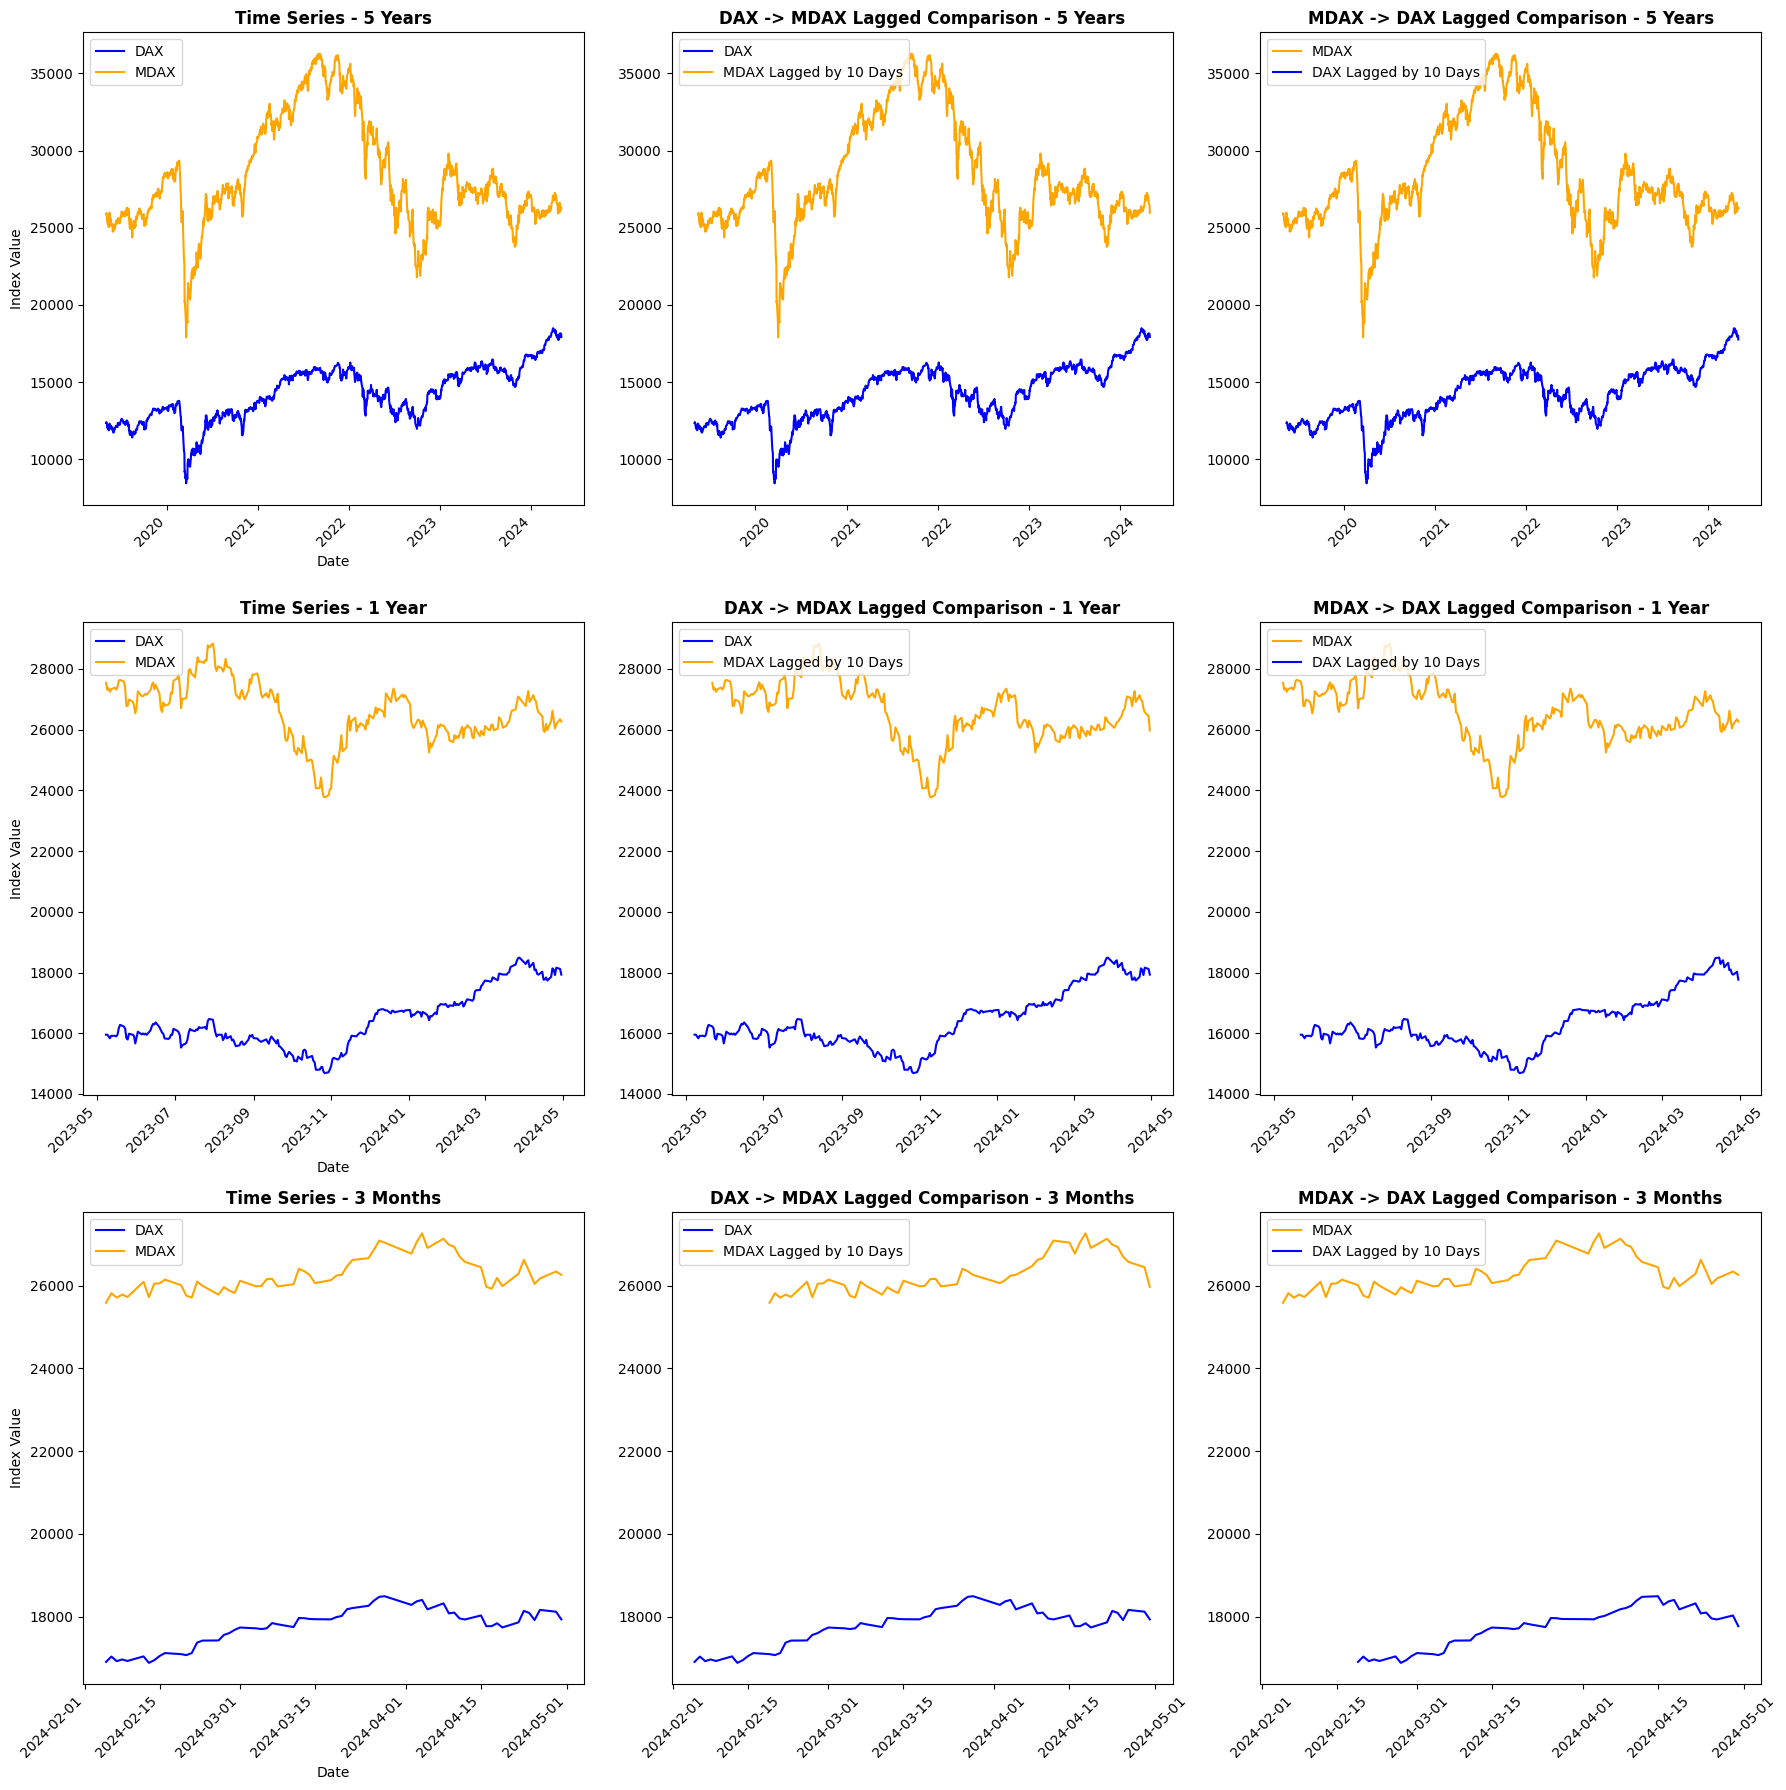

In [107]:
# Visualizations
data_1yr = data.tail(252)
data_3m = data.tail(60)

visualization_object = {
    'data': [data, data_1yr, data_3m],
    'titles': ['5 Years', '1 Year', '3 Months'],
    'lag': [10, 10, 10]  # List of significant lags for each dataframe
}

plot_time_series(visualization_object)
        